## Model Evaluation
We can see that the logistic regression model does well when most of the predictions are "good health"
This is because of dataset imbalances, we can see these below in our classification of `self-reported health`.

In [95]:
# load numpy array from csv file
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# load array
root_data_path = Path("data")

y_pred = np.loadtxt(str(root_data_path)+f"/derived_data/y_pred.csv", delimiter=',')

X_train = pd.read_csv(str(root_data_path)+f"/derived_data/eqls_2011_imputed_X_train.csv")
X_test = pd.read_csv(str(root_data_path)+f"/derived_data/eqls_2011_imputed_X_test.csv")
y_train = pd.read_csv(str(root_data_path)+f"/derived_data/eqls_2011_y_train.csv")
y_test = pd.read_csv(str(root_data_path)+f"/derived_data/eqls_2011_y_test.csv")

feature_2011_other_countries_columns = pd.read_csv(str(root_data_path)+f"/derived_data/eqls_2011_modelled.csv")

In [96]:
predictions = pd.DataFrame(y_pred)
predictions[0].value_counts()

1.0    21640
0.0     2141
Name: 0, dtype: int64

We can see that `"good health"` is almost 10x better represented than `"poor health"`.

We are able to use different techniques to reduce the imbalanced nature of the dataset we are using for training and testing.
One of these is "oversampling" from minority classes.

In [97]:
from sklearn.utils import resample
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
# separate minority and majority classes
poor_health = X[X.Health_condition_binary==0]
good_health = X[X.Health_condition_binary==1]

# upsample minority
poor_health_upsampled = resample(poor_health,
                          replace=True, # sample with replacement
                          n_samples=len(good_health), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([good_health, poor_health_upsampled])

# check new class counts
upsampled.Health_condition_binary.value_counts()

1    49222
0    49222
Name: Health_condition_binary, dtype: int64

After resampling we have an equal ratio of data points for each class! Let’s try our logistic regression again with the balanced training data.

In [98]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


In [99]:
y_train_upsampled = upsampled.Health_condition_binary
X_train_upsampled = upsampled.drop('Health_condition_binary', axis=1)


In [100]:
#Using imputer to impute missing data from upsampled data
imputed_X_train_upsampled = DataFrameImputer().fit_transform(X_train_upsampled)
imputed_X_test = DataFrameImputer().fit_transform(X_test)

Mean Absolute Error from Imputation:


/Users/clast/Documents/2021_projects/rds-course/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.11126529582439763


/Users/clast/Documents/2021_projects/rds-course/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.8887347041756024
Precision: 0.9861060137366958
Recall: 0.8876303742507905


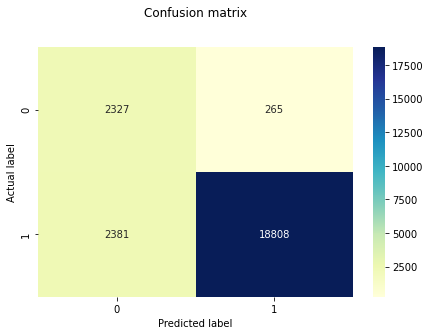

In [101]:
def logistic_regression_score_dataset(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

print("Mean Absolute Error from Imputation:")
print(logistic_regression_score_dataset(imputed_X_train_upsampled, imputed_X_test, y_train_upsampled, y_test))

def get_prediction(X_train, X_test, y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return preds


y_upsampled_pred = get_prediction(imputed_X_train_upsampled, imputed_X_test, y_train_upsampled)

cnf_matrix = metrics.confusion_matrix(y_test, y_upsampled_pred)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:",metrics.accuracy_score(y_test, y_upsampled_pred))
print("Precision:",metrics.precision_score(y_test, y_upsampled_pred))
print("Recall:",metrics.recall_score(y_test, y_upsampled_pred))


/Users/clast/Documents/2021_projects/rds-course/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


intercept for the model is: [-0.01054549]
coefficient for 'EQLS_Wave': 0.21059243303615552
coefficient for 'Country': -0.020144851846032607
coefficient for 'Marital_status': -0.0038121408393632164
coefficient for 'No_of_children': 0.03717668137001054
coefficient for 'Education_completed': 0.0818916233427986
coefficient for 'Ruralurban_living': 0.024069257229102775
coefficient for 'Citizenship__Country': -0.045460435079962044
coefficient for 'Citizenship__Another_EU_member': 0.014411699027162422
coefficient for 'Citizenship__A_nonEU_country': -0.02424251438649459
coefficient for 'Citizenship__Dont_know': -0.006488198025136537
coefficient for 'Citizenship__Refusal': -0.015950312231400338
coefficient for 'Age': -0.1709825489312338
coefficient for 'Gender': 0.06552343540583938
coefficient for 'Household_size': -0.0009270605811465749
coefficient for 'Household_size__over_18': -0.013176068401272252
coefficient for 'Household_structure': -0.011066740437469757
coefficient for 'Education__3_gro

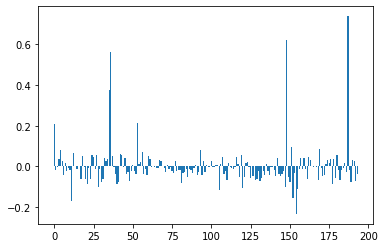

['DV_Any_limitingnot_limiting_chronic_health_problem',
 'How_satisfied_with_health',
 'Limited_by_chronic_health_problems',
 'Chronic_health_problems',
 'How_often_felt_active_and_vigorous_last_2_weeks',
 'Difficult_to_see_a_doctor_because_of_distance',
 'EQLS_Wave',
 'Age',
 'How_often_felt_cheerful_and_in_good_spirits_last_2_weeks',
 'How_frequently_take_part_in_sports_or_exercise']

In [110]:
#Creating class to retrieve coefficient info
class ModelCoeffients():
    def __init__(self, X_train, y_train):
        """Retrieves the model intercept and coefficients for model evaluation
        """
        self.X_train = X_train
        self.y_train = y_train

    def get_model_coefficients(self):
        model = LogisticRegression()
        clf = model.fit(self.X_train, self.y_train)
        return clf, list(self.X_train.columns)

    def print_model_coefficients(self):
        clf, feature_list = self.get_model_coefficients()
        print(f"intercept for the model is: {clf.intercept_}")
        coef_dict = {}
        for feature in feature_list:
            print(f"coefficient for '{feature}': {clf.coef_[0][feature_list.index(feature)]}")
            coef_dict[f"{feature}"] = clf.coef_[0][feature_list.index(feature)]
        return coef_dict

#getting coefficients for all country model with upsampling
coef_dict = ModelCoeffients(imputed_X_train_upsampled, y_train_upsampled).print_model_coefficients()
# plot feature importance
plt.bar([x for x in range(len(coef_dict.keys()))], coef_dict.values())
plt.show()

# getting top 10 features
sorted(coef_dict, key=lambda dict_key: abs(coef_dict[dict_key]), reverse=True)[:10]

The precision of the model increased, however, the model is less accurate with upsampling.

# Modelling just the UK

Here we want to select the UK from the data and see if we can build a country-specific logistic regression model.

![country-metadata]("https://raw.githubusercontent.com/alan-turing-institute/rds-course/hands-on/data-analysis/assets/metadata-country.png")

The country code for selecting the UK is `27.0`

In [111]:
feature_2011_UK_columns = feature_2011_other_countries_columns.loc[feature_2011_other_countries_columns['Country'] == 27.0]

eqls_2011_UK_target = feature_2011_UK_columns.Health_condition_binary
eqls_2011_UK_predictors = feature_2011_UK_columns.drop(['Health_condition_binary','Health_condition'], axis=1)

# For the sake of keeping the example simple, we'll use only numeric predictors.
eqls_2011_UK_numeric_predictors = eqls_2011_UK_predictors.select_dtypes(exclude=['object'])

X_train, X_test, y_train, y_test = train_test_split(eqls_2011_UK_numeric_predictors,
                                                    eqls_2011_UK_target,
                                                    train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=0)
# Imputation
imputed_X_train_UK = DataFrameImputer().fit_transform(X_train)
imputed_X_test_UK = DataFrameImputer().fit_transform(X_test)
print("Mean Absolute Error for the UK from Imputation:")
print(logistic_regression_score_dataset(imputed_X_train_UK, imputed_X_test_UK, y_train, y_test))

Mean Absolute Error for the UK from Imputation:
0.0851063829787234


/Users/clast/Documents/2021_projects/rds-course/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Exploring the feature importance for the Country-specific

In [112]:
coef_dict_UK = ModelCoeffients(imputed_X_train_UK, y_train).print_model_coefficients()

intercept for the model is: [-0.00399837]
coefficient for 'EQLS_Wave': 0.3097364833945713
coefficient for 'Country': -0.10668515944366107
coefficient for 'Marital_status': 0.006425002128762327
coefficient for 'No_of_children': 0.20857957941956926
coefficient for 'Education_completed': 0.18398314969482454
coefficient for 'Ruralurban_living': -0.06267622741312222
coefficient for 'Citizenship__Country': -0.01303784240502269
coefficient for 'Citizenship__Another_EU_member': 0.01872042461094602
coefficient for 'Citizenship__A_nonEU_country': -0.025975449430120867
coefficient for 'Citizenship__Dont_know': -0.003951302201617112
coefficient for 'Citizenship__Refusal': -0.00391703387681099
coefficient for 'Age': -0.19456397282801008
coefficient for 'Gender': -0.0866242189714268
coefficient for 'Household_size': -0.14575546041074583
coefficient for 'Household_size__over_18': -0.024070852188800566
coefficient for 'Household_structure': -0.12676322014651487
coefficient for 'Education__3_groups': -

/Users/clast/Documents/2021_projects/rds-course/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Get feature importances
The above code allows us look further at the coefficients.

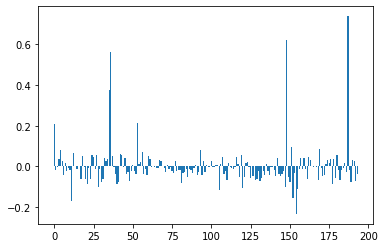

['DV_Any_limitingnot_limiting_chronic_health_problem',
 'How_satisfied_with_health',
 'Limited_by_chronic_health_problems',
 'Chronic_health_problems',
 'Difficult_to_see_a_doctor_because_of_distance',
 'EQLS_Wave',
 'How_happy_are_you',
 'Come_home_from_work_too_tired_to_do_some_of_the_household_jobs',
 'Education_completed',
 'How_much_tension_between_Old_and_Young_people']

In [113]:
# plot feature importance
plt.bar([x for x in range(len(coef_dict.keys()))], coef_dict.values())
plt.show()

#getting top 10 features from dict
sorted(coef_dict, key=coef_dict.get, reverse=True)[:10]

The above features are the most important when modelling self-reported health for

We can see that Logistic regression performs using only UK data performs similar to the total country model, suggesting that country is not a large determinant of why
individuals self-reported health. Let's retrieve this model and test it on two additional country data.

Now, Lets select two other countries from the dataset to test the transferability of this model.

In [106]:
# Selecting data for the Netherlands
feature_2011_NL_columns = feature_2011_other_countries_columns.loc[feature_2011_other_countries_columns['Country'] == 20.0]
# Selecting data for Romania
feature_2011_RO_columns = feature_2011_other_countries_columns.loc[feature_2011_other_countries_columns['Country'] == 23.0]


def create_test_data(df):
    df_target = df.Health_condition_binary
    df_predictors = df.drop(['Health_condition_binary','Health_condition'], axis=1)
    df_numeric_predictors = df_predictors.select_dtypes(exclude=['object'])
    X_train, X_test, y_train, y_test = train_test_split(df_numeric_predictors,
                                                        df_target,
                                                        train_size=0.7,
                                                        test_size=0.3,
                                                        random_state=0)
    return X_test, y_test

In [107]:
#Running the training on Netherlands and Romania
X_test_NL, y_test_NL, y_train_NL = create_test_data(feature_2011_NL_columns)
X_test_RO, y_test_RO, y_train_RO = create_test_data(feature_2011_RO_columns)

imputed_X_test_RO = DataFrameImputer().fit_transform(X_test_RO)
imputed_X_test_NL = DataFrameImputer().fit_transform(X_test_NL)

def get_fitted_model(X_train, y_train):
    model = LogisticRegression()
    return model.fit(X_train, y_train)

coef_dict_NL = ModelCoeffients(imputed_X_test_NL, y_train_NL).print_model_coefficients()
coef_dict_RO = ModelCoeffients(imputed_X_test_RO, y_train_RO).print_model_coefficients()

logistic_regression_model_UK = get_fitted_model(imputed_X_train, y_train)

y_pred_NL = logistic_regression_model_UK.predict(imputed_X_test_NL)

y_pred_RO = logistic_regression_model_UK.predict(imputed_X_test_RO)

#Getting the MAE for both countries using the UK model
print("Mean Absolute Error for Netherlands from Imputation:")
print(mean_absolute_error(y_test_NL, y_pred_NL))
print("Mean Absolute Error for Romania from Imputation:")
print(mean_absolute_error(y_test_RO, y_pred_RO))

ValueError: Found input variables with inconsistent numbers of samples: [606, 1413]

The above error statistics from the `Netherlands` and the `Romania` test set. To repeat, these are predictions are using the UK model to predict
self-reported health on test sets for Netherlands and Romania. The MAE for the predictions on Netherlands respondents is
higher than the prediction error on the UK test dataset. The Romania model performs even worse than the Netherlands predictions,
indicating that the feature importances in the UK model do not best model the features which are important in predicting
self-reported health in Romania.

Accuracy: 0.9224422442244224
Precision: 0.924496644295302
Recall: 0.9963833634719711


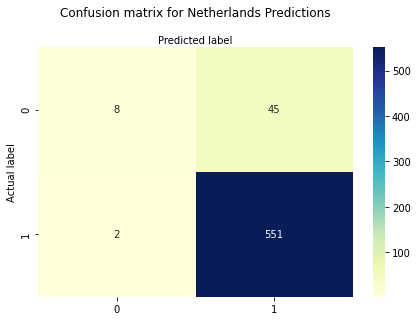

In [40]:
cnf_matrix_NL = metrics.confusion_matrix(y_test_NL, y_pred_NL)
cnf_matrix_NL

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_NL), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix for Netherlands Predictions', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:",metrics.accuracy_score(y_test_NL, y_pred_NL))
print("Precision:",metrics.precision_score(y_test_NL, y_pred_NL))
print("Recall:",metrics.recall_score(y_test_NL, y_pred_NL))


Accuracy: 0.8833551769331586
Precision: 0.8877551020408163
Recall: 0.9806763285024155


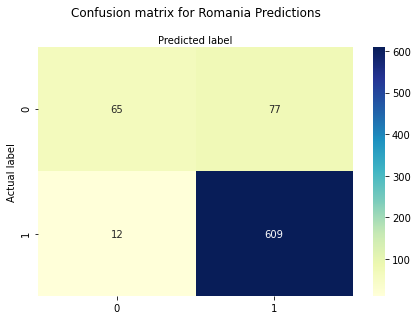

In [41]:
cnf_matrix_RO = metrics.confusion_matrix(y_test_RO, y_pred_RO)
cnf_matrix_RO

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_RO), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix for Romania Predictions', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:",metrics.accuracy_score(y_test_RO, y_pred_RO))
print("Precision:",metrics.precision_score(y_test_RO, y_pred_RO))
print("Recall:",metrics.recall_score(y_test_RO, y_pred_RO))

## References
European Foundation for the Improvement of Living and Working Conditions, (2015). European Quality of Life Time Series,
2007 and 2011: Open Access. UK Data Service. [data collection]. http://doi.org/10.5255/UKDA-SN-7724-1
